In [1]:
import os
import time
import numpy as np
import torch
from matplotlib import pyplot as plt, gridspec
from torch import nn
from torch.autograd import Variable
import torch.autograd as tgrad
from tqdm import tqdm, trange
from pyDOE import lhs



In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
seed = 1234
torch.set_default_dtype(torch.float32)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)
# device = torch.device('cuda' if use_gpu else 'cpu')
device = 'cuda'
print('Device:', device)

def is_cuda(data):
    data = data.to(device)
    return data

GPU: True
Device: cuda


In [3]:
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 130.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float()
    temp = temp.to(device)
    return temp

def train(num):
    # test data
    n_st_train = np.concatenate([np.random.uniform(*t_range, (num, 1)), 
                        np.random.uniform(*S_range, (num, 1))], axis=1)
    # n_v_train = np.zeros((num, 1))
    temp = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    return temp

# Create Neural Network and Traning Model


In [4]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).to(device)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [5]:
class Model:
    def __init__(self, net, x_label, x_labels, x_f_loss_fun,
                 x_test, x_test_exact
                 ):

        self.x_label_s = None
        self.x_f_s = None
        self.s_collect = []

        self.optimizer_LBGFS = None
        self.net = net

        self.x_label = x_label
        self.x_labels = x_labels

        self.x_f_N = None
        self.x_f_M = None

        self.x_f_loss_fun = x_f_loss_fun

        self.x_test = x_test
        self.x_test_exact = x_test_exact

        self.start_loss_collect = False
        self.x_label_loss_collect = []
        self.x_f_loss_collect = []
        self.x_test_estimate_collect = []
    
    # predict U
    def train_U(self, x):
        return self.net(x)
    
    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_e, loss_l):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
            + torch.exp(-self.x_label_s) * loss_l.detach() + self.x_label_s
        return loss

    def true_loss(self, loss_e, loss_l):
        return torch.exp(-self.x_f_s.detach()) * loss_e + torch.exp(-self.x_label_s.detach()) * loss_l

    # computer backward loss
    def epoch_loss(self):
        # x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        x_f = train(10000)
        loss_equation = self.x_f_loss_fun(x_f, self.train_U)

        loss_label = torch.mean(
            (self.train_U(self.x_label) - self.x_labels) ** 2)

        if self.start_loss_collect:
            self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
            self.x_label_loss_collect.append(
                [self.net.iter, loss_label.item()])
        return loss_equation, loss_label

    # computer backward loss
    def LBGFS_epoch_loss(self):
        self.optimizer_LBGFS.zero_grad()
        # x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        x_f = train(10000)
        loss_equation = self.x_f_loss_fun(x_f, self.train_U)
        loss_label = torch.mean(
            (self.train_U(self.x_label) - self.x_labels) ** 2)

        if self.start_loss_collect:
            self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
            self.x_label_loss_collect.append(
                [self.net.iter, loss_label.item()])

        loss = self.true_loss(loss_equation, loss_label)
        loss.backward()
        self.net.iter += 1
        print('Iter:', self.net.iter, 'Loss:', loss.item())
        return loss

    def evaluate(self):
        pred = self.train_U(self.x_test).cuda().detach().numpy()
        exact = self.x_test_exact.cuda().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def run_baseline(self):
        optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
        self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                 max_iter=lbgfs_iter)
        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            optimizer_adam.zero_grad()
            loss_e, loss_label = self.epoch_loss()
            loss = self.true_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam.step()
            self.net.iter += 1
            pbar.set_postfix({'Iter': self.net.iter,
                              'Loss': '{0:.2e}'.format(loss.item())
                              })

        print('Adam done!')
        self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
        print('LBGFS done!')

        error = self.evaluate()
        print('Test_L2error:', '{0:.2e}'.format(error))

    def run_AM_AW1(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_label_s = nn.Parameter(self.x_label_s, requires_grad=True)

        # for move_count in range(AM_count):
            
        self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr, max_iter=lbgfs_iter)
        optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
        
        optimizer_adam_weight = torch.optim.Adam([self.x_f_s] + [self.x_label_s], lr=AW_lr)

        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            self.s_collect.append([self.net.iter, self.x_f_s.item(), self.x_label_s.item()])

            loss_e, loss_label = self.epoch_loss()

            optimizer_adam.zero_grad()
            loss = self.true_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam.step()
            self.net.iter += 1
            pbar.set_postfix({'Iter': self.net.iter,
                                'Loss': '{0:.2e}'.format(loss.item())
                                })
            
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam_weight.step()

        print('Adam done!')
        self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
        print('LBGFS done!')

            # error = self.evaluate()
            # print('change_counts', move_count,
            #       'Test_L2error:', '{0:.2e}'.format(error))
            # self.x_test_estimate_collect.append(
            #     [move_count, '{0:.2e}'.format(error)])

            # if AM_type == 0:
            #     x_init = random_fun(100000)
            #     x_init_residual = abs(self.x_f_loss_fun(x_init, self.train_U))
            #     x_init_residual = x_init_residual.cuda.detach().numpy()
            #     err_eq = np.power(x_init_residual, AM_K) / \
            #         np.power(x_init_residual, AM_K).mean()
            #     err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
            #     X_ids = np.random.choice(
            #         a=len(x_init), size=M, replace=False, p=err_eq_normalized)
            #     self.x_f_M = x_init[X_ids]

            # elif AM_type == 1:
            #     x_init = random_fun(100000)
            #     x = Variable(x_init, requires_grad=True)
            #     u = self.train_U(x)
            #     dx = torch.autograd.grad(
            #         u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            #     grad_x1 = dx[:, [0]].squeeze()
            #     grad_x2 = dx[:, [1]].squeeze()
            #     dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 **
            #                     2).cuda().detach().numpy()
            #     err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
            #     p = (err_dx / sum(err_dx))
            #     X_ids = np.random.choice(
            #         a=len(x_init), size=M, replace=False, p=p)
            #     self.x_f_M = x_init[X_ids]

    def train(self):

        self.x_f_N = random_fun(N)
        self.x_f_M = random_fun(M)

        # self.x_f_s = is_cuda(-torch.log(torch.tensor(1.).float()))
        # self.x_label_s = is_cuda(
        #     -torch.log(torch.tensor(100.).float()))  # torch.exp(-self.x_label_s.detach()) = 100

        self.x_f_s = is_cuda(torch.tensor(0.).float())
        self.x_label_s = is_cuda(torch.tensor(0.).float())

        start_time = time.time()
        self.run_AM_AW1()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

# Hyperparameters

In [6]:
K = 40 # Strike price
r = 0.05 # Risk-free rate
sigma = 0.25 # Volatility
T = 1 # Time to maturity
S_range = [0, 130] # Stock price range
Smax = 130
t_range = [0, T] # Time range
gs = lambda x: np.fmax(x-K, 0) # Payoff function

layers = [2, 20, 20, 20, 20, 1] # Network structure
net = Net(layers).to(device) #  Network initialization

N = 1000 
M = 1000 
Nbc = 100 # number of boundary points

adam_iter, lbgfs_iter = 60000, 50000
adam_lr, lbgfs_lr = 0.001, 0.5

model_type = 2  # 0:baseline  1:AM  2:AM_AW

AM_type = 1  # 0:RAM  1:WAM
AM_K = 1
AM_count = 10

AW_lr = 0.001 # Learning rate for the weights

lossfunction = nn.MSELoss()

# Data Generation


In [7]:
# test data
n_st_train = np.concatenate([np.random.uniform(*t_range, (N, 1)), 
                      np.random.uniform(*S_range, (N, 1))], axis=1)
n_v_train = np.zeros((N, 1))

# bc data
# final condition (t = T, S is randomized)
f_st_train = np.concatenate([np.ones((Nbc, 1)),
                np.random.uniform(*S_range, (Nbc, 1))], axis=1)
f_v_train = gs(f_st_train[:, 1]).reshape(-1, 1)

# lower boundary condition (S = 0, t is randomized)
lb_st = np.concatenate([np.random.uniform(*t_range, (Nbc, 1)),
                    0 * np.ones((Nbc, 1))], axis=1)
lb_v = np.zeros((Nbc, 1))

# upper boundary condition (S = Smax, t is randomized)
ub_st = np.concatenate([np.random.uniform(*t_range, (Nbc, 1)), 
                    Smax * np.ones((Nbc, 1))], axis=1)
ub_v = (Smax - K*np.exp(-r*(T-ub_st[:, 0].reshape(-1)))).reshape(-1, 1)

# append boundary condition training points (edge points)
bc_st_train = np.vstack([lb_st, ub_st, f_st_train])
bc_v_train = np.vstack([lb_v, ub_v, f_v_train])


# save training data points to tensor and send to device
x_test = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
x_test_exact = torch.from_numpy(n_v_train).float().to(device)

x_bc = torch.from_numpy(bc_st_train).float().to(device)
u_bc = torch.from_numpy(bc_v_train).float().to(device)



# x_test = is_cuda(n_st_train)
# x_test_exact = is_cuda(n_v_train)

# x_bc = is_cuda(bc_st_train)
# u_bc = is_cuda(bc_v_train)

# Generate Model and Train


In [8]:
def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
        
    # PDE Round
    y1_hat = train_U(x)
    grads = tgrad.grad(y1_hat, x, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    # print(grads)
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, x, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    # print(grads2nd)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = x[:, 1].view(-1, 1)
    pde_loss = lossfunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)

    return pde_loss

In [9]:
model = Model(
    net=net,
    x_label=x_bc,
    x_labels=u_bc,
    x_f_loss_fun=x_f_loss_fun,
    x_test=x_test,
    x_test_exact=x_test_exact,
)

model.train()
print(model.x_test_estimate_collect)

 27%|███████▊                     | 16116/60000 [01:38<04:28, 163.59it/s, Iter=16116, Loss=3.33e-01]


KeyboardInterrupt: 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

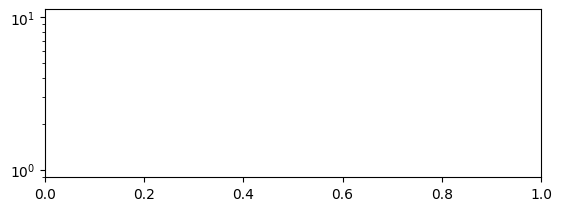

In [ ]:
def draw_epoch_loss():
    x_label_loss_collect = np.array(model.x_label_loss_collect)
    x_f_loss_collect = np.array(model.x_f_loss_collect)
    plt.subplot(2, 1, 1)
    plt.yscale('log')
    plt.plot(x_label_loss_collect[:, 0], x_label_loss_collect[:, 1], 'b-', label='Label_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.yscale('log')
    plt.plot(x_f_loss_collect[:, 0], x_f_loss_collect[:, 1], 'r-', label='PDE_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.show()

# draw_exact()
# draw_exact_points(model.x_f_M)
# draw_exact_points(model.x_f_M, show_exact=False)
# draw_exact_points(model.x_f_M, N_points=model.x_f_N)
# draw_exact_points(model.x_f_M, N_points=model.x_f_N, show_exact=False)
# draw_residual()
# draw_error()
# draw_some_t()
draw_epoch_loss()
# draw_epoch_w()